# Portfolio Optimization

In [17]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import yfinance as yf

In [18]:
# Function to read data and calculate daily returns
raw_data_path = '../data/raw/'
processed_data_path = '../data/processed/'
stocks = ['AAPL', 'AMZN', 'EEM', 'GLD', 'JNJ', 'JPM', 'SPY', 'TSLA']
training_data = [f"{raw_data_path}{stock}_training_data.csv" for stock in stocks]
validation_data = [f"{raw_data_path}{stock}_validation_data.csv" for stock in stocks]

In [19]:
def load_data(files, train: bool):
    data = {}
    for file in files:
        df = pd.read_csv(file, index_col='Date', parse_dates=True)
        data[file.split('/')[-1].split('_')[0]] = df['Close']
    data = pd.DataFrame(data)
    if train:
        data.to_csv(processed_data_path + 'training_prices.csv')
    else:
        data.to_csv(processed_data_path + 'validation_prices.csv')
    return data

def get_current_tbill_rate():
    # Fetching the 3-month T-Bill yield
    tbill = yf.Ticker("^IRX")  # 13-week Treasury bill
    hist = tbill.history(period="1d")
    current_yield = hist['Close'].iloc[-1]  # Get the last closing yield
    return current_yield / 100  # Convert to a decimal format

# Calculate portfolio performance metrics
def portfolio_performance(weights, mean_returns, cov_matrix, risk_free_rate=0.01):
    returns = np.sum(mean_returns * weights) * 252
    std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    sharpe_ratio = (returns - risk_free_rate) / std_dev
    return std_dev, returns, sharpe_ratio

def check_sum(weights):
    return np.sum(weights) - 1  # Weights must sum to 1

constraints = ({'type': 'eq', 'fun': check_sum})

def negative_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    return -portfolio_performance(weights, mean_returns, cov_matrix, risk_free_rate)[2]

def maximize_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate=0.01):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    bounds = tuple((-1, 1) for asset in range(num_assets))
    initial_guess = num_assets * [1./num_assets,]
    result = minimize(negative_sharpe_ratio, initial_guess, args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result

risk_free_rate = get_current_tbill_rate()
print(f"Current 3-month T-Bill rate: {risk_free_rate:.4%}")
# Current 3-month T-Bill rate: 5.2450% (last run)

Current 3-month T-Bill rate: 5.2380%


In [20]:
# There are 249 pieces of data from 2023-04-01 to 2024-04-01
training_prices = load_data(training_data, train=True)
test_prices = load_data(validation_data, train=False)
returns = training_prices.pct_change().dropna()
mean_returns = returns.mean()
cov_matrix = returns.cov()
risk_free_rate = 0.05245

In [21]:
optimal_portfolio = maximize_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
portfolio_volatility = None
mu = None
if optimal_portfolio.success:  # Check if the optimization was successful
    print("Optimal portfolio list:", stocks)
    print("Optimal portfolio weights:", optimal_portfolio.x)
    vol, ret, sharpe = portfolio_performance(optimal_portfolio.x, mean_returns, cov_matrix, risk_free_rate)
    portfolio_volatility = vol
    mu = ret
    print("Expected annual return:", ret)
    print("Volatility:", vol)
    print("Sharpe Ratio:", sharpe)
else:
    print("Optimization did not converge:", optimal_portfolio.message)

Optimal portfolio list: ['AAPL', 'AMZN', 'EEM', 'GLD', 'JNJ', 'JPM', 'SPY', 'TSLA']
Optimal portfolio weights: [ 0.86257053  0.36652827 -1.          0.88550737 -0.59832703  0.64971009
 -0.35608242  0.19009318]
Expected annual return: 0.9824008731891937
Volatility: 0.29327101063838285
Sharpe Ratio: 3.1709607818546632


In [22]:
weights = optimal_portfolio.x
current_prices = training_prices.iloc[-1, :]
current_portfolio_value = np.dot(current_prices, weights)
expected_annual_return = mu
print("Current Portfolio Value:", current_portfolio_value)
print("Portfolio Volatility:", portfolio_volatility)
print("Expected annual return:", expected_annual_return)

Current Portfolio Value: 245.25718132783425
Portfolio Volatility: 0.29327101063838285
Expected annual return: 0.9824008731891937


## Efficient Frontier Visualization

In [23]:
## Efficient Frontier Visualization
ef_port = pd.DataFrame(mean_returns)
ef_port = pd.merge(ef_port, pd.DataFrame(returns.std()), on = ef_port.index)
ef_port.columns = ['permno', 'ret', 'std']
ef_port['ret'] = ef_port['ret'] * 252
ef_port['std'] = ef_port['std'] * np.sqrt(252)
ef_port = pd.concat([ef_port, pd.DataFrame({'permno':['PORT'], 'ret': [ret], 'std': [vol]})])

In [24]:
def plot_efficient_frontier(mean_returns, cov_matrix, risk_free_rate, num_portfolios=1001, ef_port=None):
    num_assets = len(mean_returns)
    results = np.zeros((3, num_portfolios))
    weights_record = []
    
    target_returns = np.linspace(0, 1, num_portfolios)
    for i, target_return in enumerate(target_returns):
        constraints = ({
            'type': 'eq', 
            'fun': lambda x: portfolio_performance(x, mean_returns, cov_matrix, risk_free_rate)[1] - target_return
        }, {
            'type': 'eq', 
            'fun': lambda x: np.sum(x) - 1
        })
        bounds = tuple((-1, 1) for asset in range(num_assets))
        result = minimize(
            lambda x: portfolio_performance(x, mean_returns, cov_matrix, risk_free_rate)[0], 
            num_assets * [1. / num_assets,],
            method='SLSQP', 
            bounds=bounds, 
            constraints=constraints
        )
        if result.success:
            std_dev, returns, sharpe_ratio = portfolio_performance(result.x, mean_returns, cov_matrix, risk_free_rate)
            results[0, i] = std_dev
            results[1, i] = returns
            results[2, i] = sharpe_ratio
            weights_record.append(result.x)

    plt.figure(figsize=(10, 6))
    plt.scatter(results[0], results[1], c=results[2], cmap='viridis', marker='o')
    plt.title('Efficient Frontier with Specific Stocks')
    plt.xlabel('Portfolio Risk')
    plt.ylabel('Portfolio Return')
    plt.colorbar(label='Sharpe Ratio')
    
    if ef_port is not None:
        plt.scatter(ef_port['std'], ef_port['ret'], c='red', marker='D', s=50, label='Stocks')
        for i, txt in enumerate(ef_port['permno']):
            plt.annotate(txt, (ef_port['std'].iloc[i], ef_port['ret'].iloc[i]))

    plt.legend()
    plt.show()

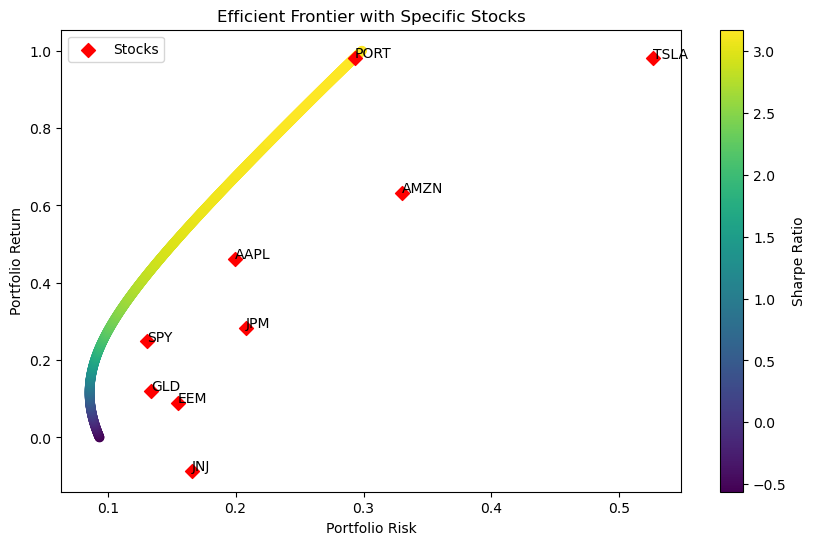

In [25]:
plot_efficient_frontier(mean_returns, cov_matrix, risk_free_rate, num_portfolios=1000, ef_port=ef_port)

## Portfolio Optimization on Simulated Prices

In [26]:
# processed_data_path = '../data/processed/'
cev_data = pd.read_csv(processed_data_path + 'simulated_prices_cev.csv', index_col=0)
heston_data = pd.read_csv(processed_data_path + 'simulated_prices_heston.csv', index_col=0)
gbm_data = pd.read_csv(processed_data_path + 'simulated_prices_gbm.csv', index_col=0)
merton_data = pd.read_csv(processed_data_path + 'simulated_prices_merton.csv', index_col=0)
gbm_data.index = cev_data.index
merton_data.index = cev_data.index
result = pd.concat([cev_data, gbm_data, heston_data, merton_data], axis=1)
result_returns = result.pct_change().dropna()
mean_returns = result_returns.mean()
cov_matrix = result_returns.cov()
risk_free_rate = 0.05245

In [27]:
test_optimal_portfolio = maximize_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
portfolio_volatility = None
mu = None
if test_optimal_portfolio.success:  # Check if the optimization was successful
    print("Optimal portfolio list:", stocks)
    print("Optimal portfolio weights:", test_optimal_portfolio.x)
else:
    print("Optimization did not converge:", optimal_portfolio.message)

Optimal portfolio list: ['AAPL', 'AMZN', 'EEM', 'GLD', 'JNJ', 'JPM', 'SPY', 'TSLA']
Optimal portfolio weights: [ 0.08020759  0.48842751  0.01711089 -0.03410461 -0.01318274  0.01907691
  0.44381824 -0.0013538 ]


 ## Performance Comparison

In [28]:
test_returns = test_prices.pct_change().dropna()
test_mean_returns = test_returns.mean()
test_cov_matrix = test_returns.cov()
test_vol1, test_ret1, test_sharpe1 = portfolio_performance(optimal_portfolio.x, test_mean_returns,test_cov_matrix, risk_free_rate)
print("Portfolio Performance Using Optimized Weight from Historical Price")
print("Optimal portfolio weights:", optimal_portfolio.x)
print("Expected annual return:", test_ret1)
print("Volatility:", test_vol1)
print("Sharpe Ratio:", test_sharpe1)

Portfolio Performance Using Optimized Weight from Historical Price
Optimal portfolio weights: [ 0.86257053  0.36652827 -1.          0.88550737 -0.59832703  0.64971009
 -0.35608242  0.19009318]
Expected annual return: 0.20086236848655734
Volatility: 0.22385806865371366
Sharpe Ratio: 0.6629752922425889


In [29]:
test_vol2, test_ret2, test_sharpe2 = portfolio_performance(test_optimal_portfolio.x, test_mean_returns,test_cov_matrix, risk_free_rate)
print("Portfolio Performance Using Optimized Weight from Simulated Price")
print("Optimal portfolio weights:", test_optimal_portfolio.x)
print("Expected annual return:", test_ret2)
print("Volatility:", test_vol2)
print("Sharpe Ratio:", test_sharpe2)

Portfolio Performance Using Optimized Weight from Simulated Price
Optimal portfolio weights: [ 0.08020759  0.48842751  0.01711089 -0.03410461 -0.01318274  0.01907691
  0.44381824 -0.0013538 ]
Expected annual return: 0.575742773683335
Volatility: 0.17687080420019655
Sharpe Ratio: 2.958615900739787


In [34]:
portfolio_path_old = result @ optimal_portfolio.x
portfolio_path_old = pd.DataFrame(portfolio_path_old, columns=['Portfolio Value'])
portfolio_path_new = result @ test_optimal_portfolio.x
portfolio_path_new = pd.DataFrame(portfolio_path_new, columns=['Portfolio Value'])

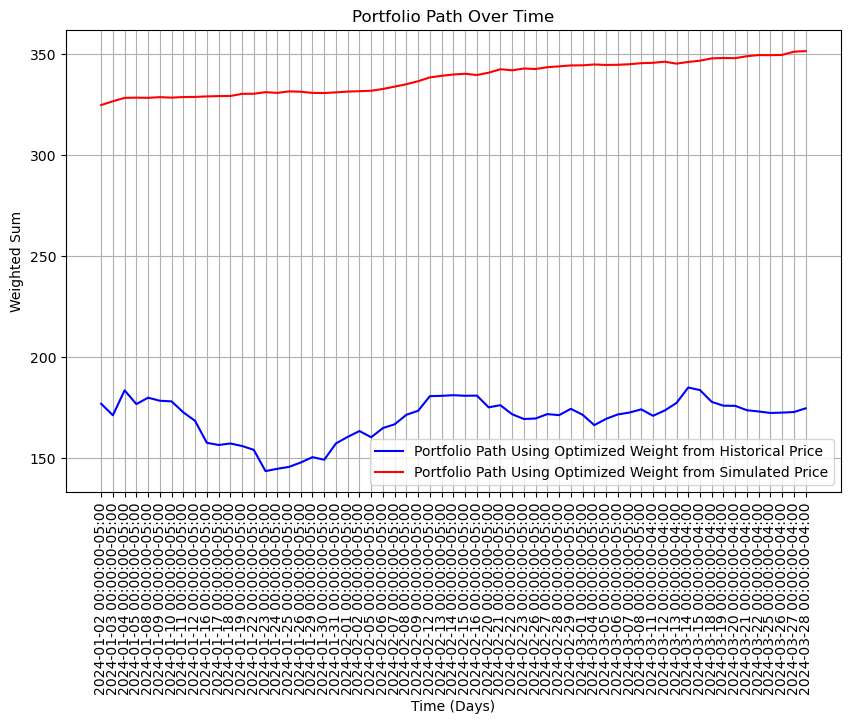

In [36]:
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(portfolio_path_old.index, portfolio_path_old['Portfolio Value'], label='Portfolio Path Using Optimized Weight from Historical Price', color='blue')
plt.plot(portfolio_path_new.index, portfolio_path_new['Portfolio Value'], label='Portfolio Path Using Optimized Weight from Simulated Price', color='red')
plt.title('Portfolio Path Over Time')  # Title of the plot
plt.xlabel('Time (Days)')  # Label for the x-axis
plt.ylabel('Weighted Sum')  # Label for the y-axis
plt.legend()  # Add a legend
plt.grid(True)  # Show grid
# Rotate x-axis labels to be vertical
plt.xticks(rotation=90)
plt.show()  # Display the plot

## Add Options

In [32]:
portfolio_path_df['Daily P&L'] = portfolio_path_df['Portfolio Value'].diff()
portfolio_path_df['Daily P&L'] = portfolio_path_df['Daily P&L'].fillna(0)
portfolio_path_df['Cumulative P&L'] = portfolio_path_df['Daily P&L'].cumsum()
portfolio_path_df['Cumulative P&L']
# plt.figure(figsize=(10, 6))  # Set the figure size
# plt.plot(portfolio_path.index, portfolio_path_df['Cumulative P&L'], label='Cumulative P&L', color='blue')
# plt.title('Portfolio Cumulative P&L Over Time')  # Title of the plot
# plt.xlabel('Time (Days)')  # Label for the x-axis
# plt.ylabel('Weighted Sum')  # Label for the y-axis
# plt.legend()  # Add a legend
# plt.grid(True)  # Show grid
# plt.show()  # Display the plot

Date
2024-01-02 00:00:00-05:00    0.000000
2024-01-03 00:00:00-05:00   -5.720838
2024-01-04 00:00:00-05:00    6.619584
2024-01-05 00:00:00-05:00   -0.177230
2024-01-08 00:00:00-05:00    2.975960
                               ...   
2024-03-22 00:00:00-04:00   -3.847191
2024-03-25 00:00:00-04:00   -4.577199
2024-03-26 00:00:00-04:00   -4.402197
2024-03-27 00:00:00-04:00   -4.128055
2024-03-28 00:00:00-04:00   -2.287150
Name: Cumulative P&L, Length: 61, dtype: float64